In [1]:
from nufeb_tools import utils,plot,stats
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist,squareform
from scipy.spatial import KDTree
from scipy.spatial import Voronoi, voronoi_plot_2d
#import skgeom as sg
from tqdm import tqdm
from pathlib import Path
import dask
from dask import dataframe as dd
from joblib import Parallel, delayed

In [4]:

dirs = [r'D:\runs\Run_50_50_10_1_2021-07-27',r'D:\runs\Run_50_50_45_1_2021-07-27',r'D:\runs\Run_50_50_100_1_2021-07-27']
with Parallel(n_jobs=-1) as parallel:
        temp = parallel(delayed(utils.get_data)(directory=dir) for dir in dirs)
metrics = [stats.fitness_metrics(x) for x in temp]

C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [4]:
pd.concat(metrics)

,mother_cell,type,Voronoi Area,sucRatio,total biomass,Nearest1,Nearest2,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area
0,94,2,5.969102e-09,10,49129.528522,0.000010,0.000008,97128.586236,130130.916394,22.967582,23.552593,26123.0
1,52,2,5.143321e-09,10,52969.957904,0.000004,0.000008,268811.376854,130130.916394,25.003530,23.552593,24321.0
2,68,2,1.462776e-10,10,49032.283116,0.000012,0.000006,85831.376519,159510.733390,22.720280,23.959733,21879.0
3,63,2,1.236506e-10,10,54285.479921,0.000009,0.000006,109755.995542,159510.733390,23.212030,23.959733,21987.0
4,59,2,3.450107e-10,10,32181.792371,0.000010,0.000006,104874.015794,170008.539743,23.121030,24.087208,14328.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,69,2,1.454736e-10,100,195915.503222,0.000004,0.000009,222803.922175,115076.093909,24.628095,23.306698,52652.0
96,96,2,3.006473e-10,100,435683.874800,0.000011,0.000009,93504.344177,116236.565382,22.891526,23.326766,98179.0
97,70,2,1.411027e-10,100,402426.250590,0.000014,0.000009,70899.718363,106822.488573,22.338043,23.157848,110065.0
98,91,2,1.337155e-10,100,297125.047394,0.000007,0.000009,142259.601013,106822.488573,23.730818,23.157848,74419.0


In [2]:
BASE_DIR = Path(f'../simulation-data/runs')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
def collect_data(folders):
    dfs = list()
    for folder in tqdm(folders):
        a = utils.get_data(directory=str(folder))
        b = stats.fitness_metrics(a)
        dfs.append(b)

    return pd.concat(dfs)

In [5]:
def collect_data(folder):
    a = utils.get_data(directory=str(folder))
    b = stats.fitness_metrics(a)
    return b

with Parallel(n_jobs=-1) as parallel:
    temp = parallel(delayed(collect_data)(folder) for folder in tqdm(folders[:20]))
data = pd.concat(temp)

100%|██████████| 20/20 [00:00<00:00, 10003.11it/s]


In [13]:
data.notna()

,mother_cell,type,Voronoi Area,sucRatio,total biomass,Nearest1,Nearest2,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area
0,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
95,True,True,True,True,True,True,True,True,True,True,True,True
96,True,True,True,True,True,True,True,True,True,True,True,True
97,True,True,True,True,True,True,True,True,True,True,True,True
98,True,True,True,True,True,True,True,True,True,True,True,True


In [26]:
metric2 = data[data.type==2].fillna(0)
import statsmodels.api as sm
metric_list = ['Colony Area','Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2','sucRatio']
y = metric2['total biomass']
def get_stats():
    x = metric2[metric_list]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                            OLS Regression Results                            
Dep. Variable:          total biomass   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     4207.
Date:                Mon, 13 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:22:47   Log-Likelihood:                -11007.
No. Observations:                1000   AIC:                         2.203e+04
Df Residuals:                     991   BIC:                         2.208e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Colony Area      3.5997      0.020    182.386   

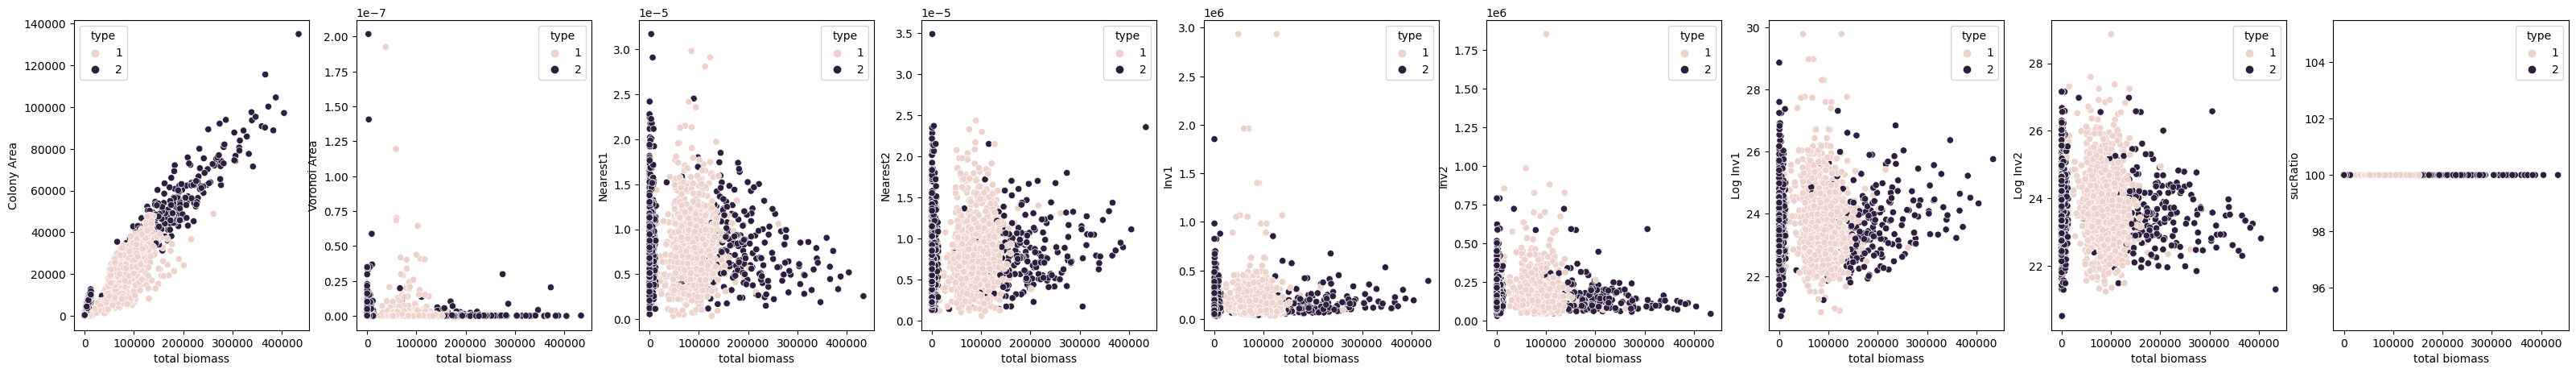

In [27]:

f, axes = plt.subplots(ncols=len(metric_list),figsize=(40,5))
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
plt.show()
#for ax in axes.ravel():
   # ax.set_xscale('log')
   # ax.set_yscale('log')


In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [34]:
metric_list = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2','sucRatio']
to_scale = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2','sucRatio','total biomass']
scaled_df = data.copy()
scaled_df[to_scale] = scaler.fit_transform(data[to_scale])
scaled_df

,mother_cell,type,Voronoi Area,sucRatio,total biomass,Nearest1,Nearest2,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area
0,99,2,0.220538,0.0,0.779175,-0.522293,0.089200,-0.012109,-0.394906,0.313915,-0.318601,43532.0
1,60,2,-0.163607,0.0,0.624278,0.480602,0.929410,-0.438263,-0.694876,-0.637845,-0.956222,38679.0
2,84,2,0.004122,0.0,1.048374,-0.660376,1.230175,0.096887,-0.765007,0.494470,-1.141448,49565.0
3,70,2,0.291438,0.0,0.456056,2.542806,0.433177,-0.722094,-0.542164,-1.747182,-0.605484,42854.0
4,86,2,-0.155044,0.0,0.189685,-0.835390,-0.341727,0.272475,-0.127181,0.752359,0.113853,28831.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,2,-0.173601,0.0,-1.001150,0.604177,1.379904,-0.467978,-0.795346,-0.727056,-1.227433,633.0
96,87,2,-0.152125,0.0,-1.003132,1.476141,-0.843568,-0.617441,0.423865,-1.256730,0.781455,450.0
97,99,2,0.368681,0.0,-1.002905,1.289153,0.889783,-0.592083,-0.684569,-1.155359,-0.930438,450.0
98,96,2,-0.163064,0.0,-1.003077,0.851488,-0.843568,-0.519686,0.423865,-0.893498,0.781455,350.0


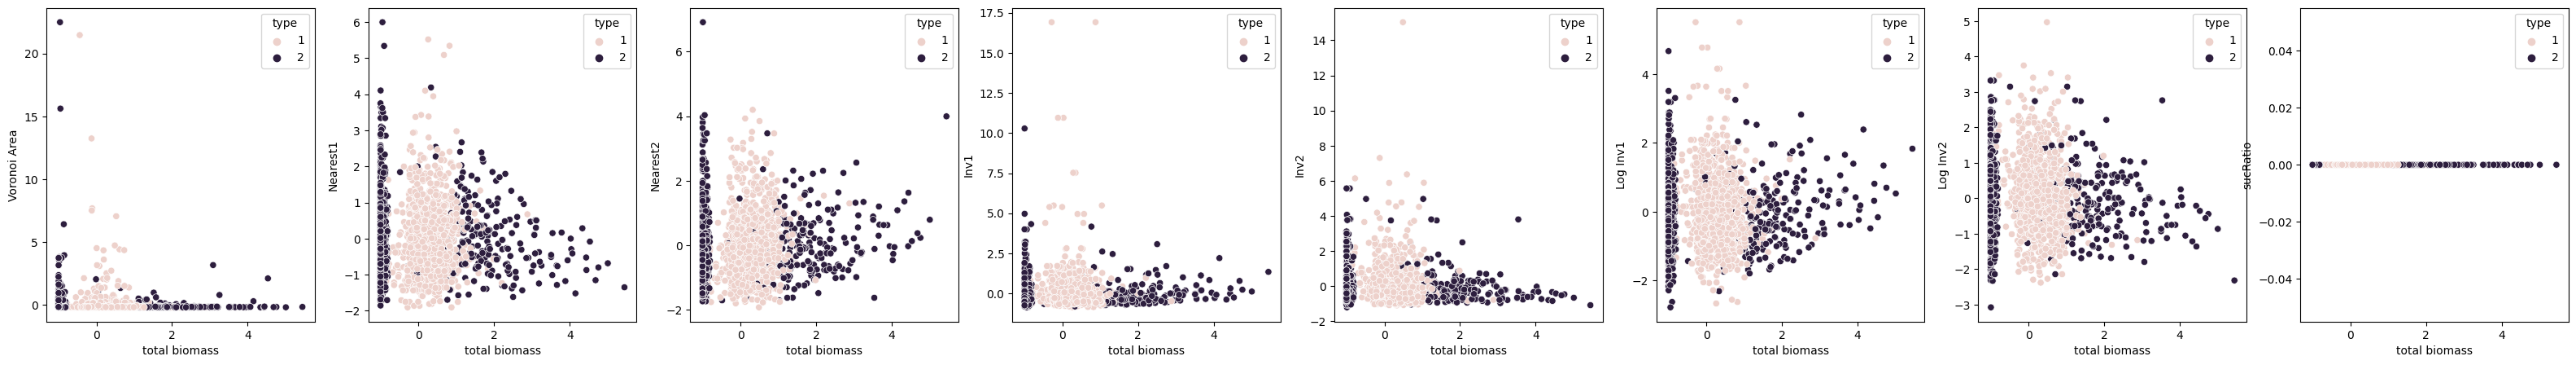

In [37]:

f, axes = plt.subplots(ncols=len(metric_list),figsize=(40,5))
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=scaled_df,ax=ax)
plt.show()

In [44]:
from sklearn.model_selection import train_test_split
cols = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2']
y = scaled_df[scaled_df.type==2]['total biomass']
X = scaled_df[scaled_df.type==2][cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y,X[included]).fit()
        pvalues = model.pvalues
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [70]:
reg_mets = backward_regression(data[cols], data['total biomass'], threshold_out=.09,
                           verbose=True)
reg_mets

Drop Log Inv1                       with p-value 0.893816
Drop Inv1                           with p-value 0.550867
Drop Inv2                           with p-value 0.155775
Drop Nearest1                       with p-value 0.104506


['Voronoi Area', 'Nearest2', 'Log Inv2']

In [45]:
s2 = scaled_df[scaled_df.type==2]

In [46]:
reg_mets = backward_regression(s2[cols], s2['total biomass'], threshold_out=.05,
                           verbose=True)

Drop Inv1                           with p-value 0.68578
Drop Log Inv1                       with p-value 0.671927
Drop Inv2                           with p-value 0.492156
Drop Nearest2                       with p-value 0.511228
Drop Voronoi Area                   with p-value 0.262322
Drop Log Inv2                       with p-value 0.0560334


In [75]:
cols = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2']
y = data[data.type==2]['total biomass']
X = data[data.type==2][reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.237
Model:                            OLS   Adj. R-squared (uncentered):              0.235
Method:                 Least Squares   F-statistic:                              103.4
Date:                Mon, 13 Sep 2021   Prob (F-statistic):                    2.72e-58
Time:                        17:58:29   Log-Likelihood:                         -12782.
No. Observations:                1000   AIC:                                  2.557e+04
Df Residuals:                     997   BIC:                                  2.558e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

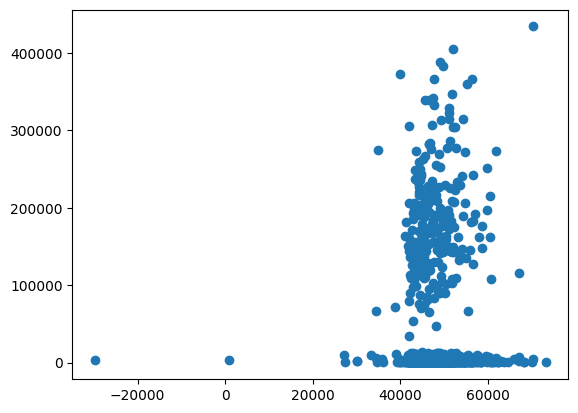

In [77]:
plt.scatter(predictions,y)
plt.show()

In [60]:
s2[reg_mets]

,Nearest2,Log Inv2
0,0.089200,-0.318601
1,0.929410,-0.956222
2,1.230175,-1.141448
3,0.433177,-0.605484
4,-0.341727,0.113853
...,...,...
95,1.379904,-1.227433
96,-0.843568,0.781455
97,0.889783,-0.930438
98,-0.843568,0.781455


In [55]:
pred = result.predict(s2[reg_mets])
f, ax = plt.subplots()
ax.scatter(x=s2['total biomass'],y=pred)
#ax.plot([-1,2],[-1,2], transform=ax.transAxes)

ValueError: shapes (1000,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)

In [57]:
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
names=pd.DataFrame(X.columns)

#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 4, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

    Feature  Rank
1  Nearest1     1
2  Nearest2     1
4      Inv2     1
6  Log Inv2     1


C:\Users\Jonathan\anaconda3\envs\pyscaffold\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


4

In [59]:
lin_reg.fit(X,y)
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)

Intercept: 
 -0.298116077967309
Coefficients: 
 [-0.0441822  -0.07368177 -0.2249693  -0.06541859  0.17509542  0.03615201
 -0.45368303]


<AxesSubplot:xlabel='Timestep', ylabel='mother_cell'>

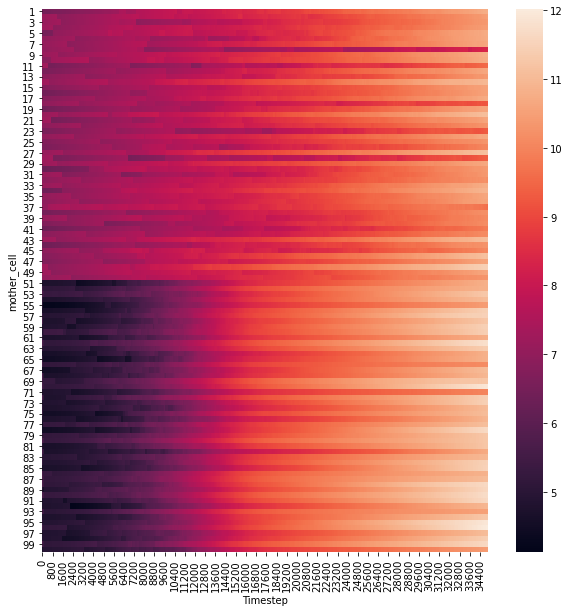

In [70]:

data = df.copy()
data['sum'] = df.groupby(['mother_cell','Timestep'])['biomass'].cumsum()
data['sum'] = np.log(data['sum'])
pivs = data.pivot_table(index='mother_cell', columns='Timestep', values='sum')
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pivs,ax=ax)
